In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Predictive Regression Modeling Workflow

This dataset was downloaded from [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho) and contains information about used car sale listings.  We are trying to predict the price associated with the listing.

### Features (as described on Kaggle)
 - `Car_Name`: The name of the car
 - `Year`: The year in which the car was bought
 - `Selling_Price`: The price the owner wants to sell the car at
 - `Present_Price`: The current ex-showroom price of the car
 - `Kms_Driven`: The distance completed by the car in km
 - `Fuel_Type`: The fuel type of the car (`Petrol`, `Diesel`, or Other)
 - `Seller_Type`: Whether the seller is a dealer or an individual
 - `Transmission`: Whether the car is manual or automatic
 - `Owner`: The number of owners the car has previously had

Looking at the original website, it looks like the prices are listed in lakhs, meaning hundreds of thousands of rupees.

In [2]:
df = pd.read_csv("cars.csv")

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

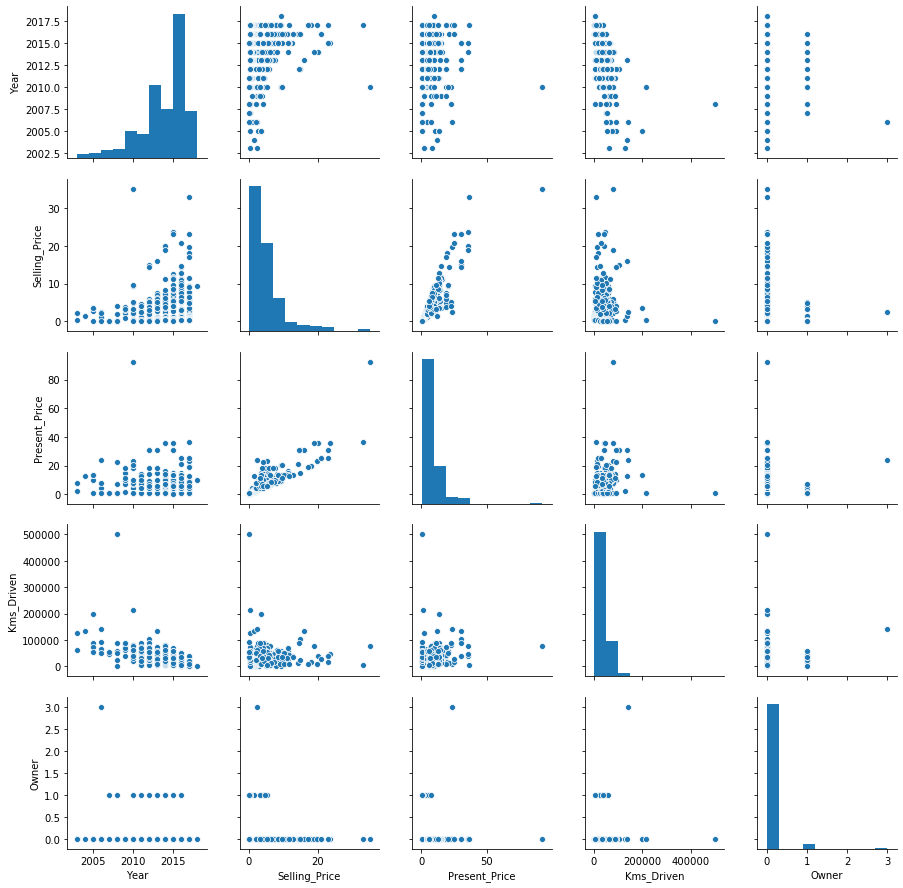

In [6]:
sns.pairplot(df)

## Train-Test Split

Before performing any preprocessing or modeling, set aside a holdout test set

In [7]:
X = df.drop("Selling_Price", axis=1)
y = df["Selling_Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline Model: Linear Regression with Numeric Features Only

We have four numeric features (`Year`, `Present_Price`, `Kms_Driven`, and `Owner`) and four non-numeric features (`Car_Name`, `Fuel_Type`, `Seller_Type`, `Transmission`).  Before doing any of the engineering work to be able to use those non-numeric features, let's just try using the numeric ones

In [8]:
lin_reg_model = LinearRegression()

X_train_numeric = X_train[["Year", "Present_Price", "Kms_Driven", "Owner"]].copy()

In [18]:
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train_numeric, y_train, cv=5)
baseline_cross_val_score

array([0.67168559, 0.75626366, 0.88591659, 0.79241643, 0.84299344])

Ok, not too bad, we are getting somewhere between 0.67 and 0.89 r-squared for a linear regression with just the numeric features

## Add One-Hot Encoded Features

Let's see if adding in some of those non-numeric features helps

In [10]:
# resetting the index so we can concatenate the one-hot encoded dfs more easily
X_train_all_features = X_train.copy().reset_index().drop("index", axis=1)

In [11]:
def encode_and_concat_feature_train(X_train_all_features, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train_all_features[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train_all_features = encode_and_concat_feature(X_train_all_features, feature_name, ohe)
    
    return ohe, X_train_all_features

In [12]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0])
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [13]:
# we will need each of these encoders later for transforming the test data

fuel_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Fuel_Type")
seller_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Seller_Type")
transmission_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Transmission")
# putting car name at the end just because there are the most categories
car_name_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Car_Name")

In [14]:
X_train_all_features.columns

Index(['Year', 'Present_Price', 'Kms_Driven', 'Owner', 'CNG', 'Diesel',
       'Petrol', 'Dealer', 'Individual', 'Automatic', 'Manual', '800',
       'Activa 3g', 'Bajaj  ct 100', 'Bajaj Avenger 150',
       'Bajaj Avenger 150 street', 'Bajaj Avenger 220',
       'Bajaj Avenger 220 dtsi', 'Bajaj Avenger Street 220',
       'Bajaj Discover 100', 'Bajaj Discover 125', 'Bajaj Dominar 400',
       'Bajaj Pulsar 135 LS', 'Bajaj Pulsar 150', 'Bajaj Pulsar 220 F',
       'Bajaj Pulsar NS 200', 'Bajaj Pulsar RS200', 'Hero  Ignitor Disc',
       'Hero Extreme', 'Hero Glamour', 'Hero Honda Passion Pro', 'Hero Hunk',
       'Hero Passion Pro', 'Hero Passion X pro', 'Hero Splender Plus',
       'Hero Splender iSmart', 'Hero Super Splendor', 'Honda Activa 4G',
       'Honda CB Hornet 160R', 'Honda CB Shine', 'Honda CB Unicorn',
       'Honda CB twister', 'Honda CBR 150', 'Honda Karizma', 'Hyosung GT250R',
       'KTM 390 Duke ', 'KTM RC200', 'KTM RC390', 'Royal Enfield Bullet 350',
       'Royal En

In [15]:
X_train_all_features

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,...,innova,jazz,land cruiser,omni,ritz,swift,sx4,verna,wagon r,xcent
0,2017,0.84,5000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,14.79,12900,0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,0.32,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,13.60,21780,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,5.90,14465,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2013,0.57,18000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,2011,12.48,45000,0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,2014,3.45,16500,1,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,2011,10.00,69341,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear Regression with More Features

In [19]:
lin_reg_model = LinearRegression()

print("Old:", baseline_cross_val_score)
print("New:", cross_val_score(lin_reg_model, X_train_all_features, y_train, cv=5))

Old: [0.67168559 0.75626366 0.88591659 0.79241643 0.84299344]
New: [ 5.37672694e-01 -7.38091761e+12  9.16586477e-01  7.58859065e-01
  7.52699829e-01]


In [17]:
! conda list scikit-learn

# packages in environment at /Users/ehoffman/.conda/envs/prework-labs:
#
# Name                    Version                   Build  Channel
scikit-learn              0.22             py37h3dc85bc_1    conda-forge


That looks worse.  What if we don't use the car name, and just use the categories with 1-3 values?

In [20]:
X_train_all_except_car_name = X_train_all_features[[
                    "Year",
                    "Present_Price",
                    "Kms_Driven",
                    "Owner",
                    "CNG",
                    "Diesel",
                    "Petrol",
                    "Dealer",
                    "Individual",
                    "Automatic",
                    "Manual"
                ]].copy()
X_train_all_except_car_name

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,Manual
0,2017,0.84,5000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,2015,14.79,12900,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,2015,0.32,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,2015,13.60,21780,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2015,5.90,14465,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
220,2013,0.57,18000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
221,2011,12.48,45000,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
222,2014,3.45,16500,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0
223,2011,10.00,69341,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [21]:
lin_reg_model = LinearRegression()

print("Old:", baseline_cross_val_score)
print("New:", cross_val_score(lin_reg_model, X_train_all_except_car_name, y_train, cv=5))

Old: [0.67168559 0.75626366 0.88591659 0.79241643 0.84299344]
New: [0.71773298 0.65008625 0.92349676 0.81151078 0.88264199]


In [38]:
lin_reg_model.fit(X_train_all_except_car_name, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
lin_reg_model.coef_

array([ 3.66737867e-01,  4.24013125e-01, -5.41982063e-06, -1.01134981e+00,
       -1.09963446e+00,  1.42995678e+00, -3.30322320e-01,  6.31302952e-01,
       -6.31302952e-01,  7.77845019e-01, -7.77845019e-01])

In [40]:
lin_reg_model.intercept_

-736.3855028465609

In [41]:
lin_reg_model.rank_

8

In [42]:
lin_reg_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

Ok, adding these categories improved r-squared for 4 out of 5 subsamples compared to just having numeric features, so let's keep them for our linear regression model

In [22]:
best_linreg_cross_val_score = cross_val_score(lin_reg_model, X_train_all_except_car_name, y_train)

## Try a More Advanced Model

It depends on our business case whether these numbers are sufficient.  We are explaining approximately somewhere between 65% and 92% of the variance in the sale price.  But let's try a more complicated model.

First, just using the X_train values used in the linear regression:

In [24]:
random_forest_regressor_model_1 = RandomForestRegressor(n_estimators=10, random_state=42)

print("Old:", best_linreg_cross_val_score)
print("New:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train, cv=5))

Old: [0.71773298 0.65008625 0.92349676 0.81151078 0.88264199]
New: [0.83102658 0.66532476 0.90650579 0.81714334 0.92862009]


Ok, this more-sophisticated model is performing slightly better on 4 of 5 subsamples than the best linear regression score.  Let's see what happens if we add the car names back in:

In [25]:
random_forest_regressor_model_2 = RandomForestRegressor(n_estimators=10, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train, cv=5))
print("New:", cross_val_score(random_forest_regressor_model_2, X_train_all_features, y_train, cv=5))

Old: [0.83102658 0.66532476 0.90650579 0.81714334 0.92862009]
New: [0.8120682  0.7237103  0.90434184 0.80154837 0.92665771]


Only one of the subsamples improved with adding this feature, and everything else got worse

## Hyperparameter Tuning the More Advanced Model

Let's add some more "power" to the random forest regressor, since it's running reasonably quickly right now

In [26]:
random_forest_regressor_model_3 = RandomForestRegressor(n_estimators=1000, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train, cv=5))
print("New:", cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train, cv=5))

Old: [0.83102658 0.66532476 0.90650579 0.81714334 0.92862009]
New: [0.85347083 0.72854389 0.90506631 0.83936817 0.93520377]


That marginally improved 4 of the 5 subsamples (but was significantly slower to run).  Let's try including the car name again:

In [27]:
random_forest_regressor_model_4 = RandomForestRegressor(n_estimators=1000, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train))
print("New:", cross_val_score(random_forest_regressor_model_4, X_train_all_features, y_train))

Old: [0.85347083 0.72854389 0.90506631 0.83936817 0.93520377]
New: [0.82470832 0.71709424 0.89251424 0.8456903  0.93846238]


Again, that didn't really seem to help.  So if we're stopping right now, we can say that the third random forest regressor is the best model.

## Model Evaluation

Now that we have chosen a best model, let's use the holdout set to see how well the final model does

First, perform all of the same transformations on the test X that were performed on the train X

In [28]:
X_test_all_except_car_name = X_test.reset_index().drop(["index", "Car_Name"], axis=1)

# fuel_type_ohe, seller_type_ohe, and transmission_ohe were fitted on the training data
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Fuel_Type", fuel_type_ohe)
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Seller_Type", seller_type_ohe)
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Transmission", transmission_ohe)

X_test_all_except_car_name

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,Manual
0,2016,0.57,24000,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2016,13.60,10980,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,2012,9.40,60000,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2011,0.57,35000,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,2013,18.61,40001,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
71,2011,8.01,50000,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
72,2016,7.90,28569,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
73,2015,7.27,40534,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
74,2012,4.43,23709,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


Fit our best model on all of the training data

In [29]:
random_forest_regressor_model_3.fit(X_train_all_except_car_name, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Score our best model on the test data

In [30]:
random_forest_regressor_model_3.score(X_test_all_except_car_name, y_test)

0.9706072528266274

That's pretty good!  We have a model that is able to explain 97% of the variance in the car sale list prices

To report something more applicable to a business audience, let's calculate the [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [32]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, random_forest_regressor_model_3.predict(X_test_all_except_car_name))

0.8075452595118476

In [44]:
np.sqrt(0.8075452595118476)

0.8986352204937483

To interpret this: on average, our prediction of `Selling_Price` is off (either too high or too low) by about 0.9 lakh, i.e. about 90,000 rupees (about 1200 USD)

Also, here is a plot that shows the actual vs. predicted prices:

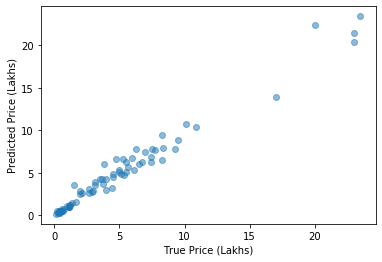

In [47]:
fig, ax = plt.subplots()

ax.set_xlabel("True Price (Lakhs)")
ax.set_ylabel("Predicted Price (Lakhs)")

ax.scatter(y_test, random_forest_regressor_model_3.predict(X_test_all_except_car_name), alpha=0.5);

You can see that this model performs quite well on the lower end of price, then makes more mistakes as price increases, particularly beyond 10 lakhs.

If we had made this plot _before_ the evaluation phase, maybe we could go back to figure out if there is any additional feature engineering that would help improve the predictions for higher priced cars (e.g. extracting the make from the car name).  But since this is the final evaluation phase, that would be "cheating" since it would incorporate information from the test data in the modeling phase.  Later we'll discuss overfitting and why this is a problem.

## Similarities and Differences with Inferential Regression Workflow

### Same
 - Data understanding process (looking at what kinds of features we have, trying to understand the relationship to the target)
 - Starting with a baseline model, then building more and checking how well they performed
 - Preprocessing needed to prepare categorical variables (all features need to be numeric for the model to understand them)
 - Doing a regression analysis and looking at r-squared to see how much of the variance is explained
 - Evaluate model at the end

### Different
 - Checking model performance along the way
    - For predictive, we only looked at the metric of interest (r-squared in this case) and not anything else
    - Assumptions of linear regression (linearity, normality, homoscedasticiy, independence)
       - Checked for these in inferential but not in predictive
       - For inferential, our FSM had only one feature because we were doing these checks at each phase.  For predictive, we added all numeric features into the FSM.
    - Coefficients and their p-values
       - For inferential, checked these repeatedly in the modeling and evaluation process
       - For predictive, didn't really need to check coefficients at all (although we did towards the end out of curiousity), and never checked p-values
 - Models used
    - Different packages (sklearn for predictive, statsmodels for inferential) to run the linear regressions
      - Statsmodels gives a lot more information in the model summary that we don't get from the sklearn's linear regression
    - For predictive, we used models other than a linear regression (RandomForestRegressor), inferential only used linear regression
      - More advanced models like RandomForestRegressor have hyperparameters we can tune
      - Have to specify a random_state if we want the same behavior each time
 - Train-test split
    - For inferential, we just used all available rows every time we fit the model
    - For predictive, we had a test data set that was used for evaluation at the end
    - For predictive, we also used `cross_val_score` every time instead of just fitting to everything in `X_train`
 - One-hot encoding (_I added this after the lesson ended_)
    - For inferential, dropped the first one of any given category
    - For predictive, didn't drop any